# 0- Fit the tree ring center

Author: Johnny Esteves, University Of Michigan

### Description
In this notebook, you'll measure the tree ring center fit on super flat field images for the R02 S02 (ITL) and R22 S11 (e2v) sensors.



In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import fitsio as fits

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()


import numpy as np

from scipy.stats import binned_statistic_2d, binned_statistic
from skimage.measure import block_reduce
from skimage.util import view_as_blocks
from scipy.ndimage.filters import gaussian_filter
import scipy.optimize as opt

In [3]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(obj=None, ax=None, size="5%", pad=0.1):
    should_restore = False

    if obj is not None:
        ax = obj.axes
    elif ax is None:
        ax = plt.gca()
        should_restore = True

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)

    plt.colorbar(obj, cax=cax)

    if should_restore:
        plt.sca(ax)
        
def imshow(image, qq=[0.5,97.5], show_colorbar=True, **kwargs):
    vmin1,vmax1 = np.percentile(image[np.isfinite(image)], qq)
    if 'vmin' not in kwargs.keys():
        kwargs['vmin'] = vmin1
    if 'vmax' not in kwargs.keys():
        kwargs['vmax'] = vmax1
    plt.imshow(image, **kwargs)
    if show_colorbar:
        colorbar()

In [6]:
import numpy
import scipy

def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, 'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, 'Block shape[1] does not evenly divide array shape[1].'
    shape = (A.shape[0] / block_shape[0], A.shape[1] / block_shape[1]) + block_shape
    strides = (block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides
    
    return numpy.lib.stride_tricks.as_strided(A, shape=np.array(shape).astype(int), strides=np.array(strides).astype(int))

def apply_filter(A, smoothing, power=2.0):
    """Apply a hi/lo pass filter to a 2D image.
    
    The value of smoothing specifies the cutoff wavelength in pixels,
    with a value >0 (<0) applying a hi-pass (lo-pass) filter. The
    lo- and hi-pass filters sum to one by construction.  The power
    parameter determines the sharpness of the filter, with higher
    values giving a sharper transition.
    """
    if smoothing == 0:
        return A
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

def zero_by_region(data, region_shape, num_sigmas_clip=8.0, smoothing=250, power=4):
    """Subtract the clipped median signal in each amplifier region.
    
    Optionally also remove any smooth variation in the mean signal with
    a high-pass filter controlled by the smoothing and power parameters.
    Returns a an array of median levels in each region and a mask of
    unclipped pixels.
    """
    mask = np.zeros_like(data, dtype=bool)

    # Loop over amplifier regions.
    regions = block_view(data, region_shape)
    masks  = block_view(mask, region_shape)
    ny, nx = regions.shape[:2]
    levels = np.empty((ny, nx))
  
    for y in range(ny):
        for x in range(nx):
            region_data = regions[y, x]
            region_mask = masks[y, x]
            clipped1d, lo, hi = scipy.stats.sigmaclip(
                region_data, num_sigmas_clip, num_sigmas_clip)
            # Add unclipped pixels to the mask.
            region_mask[(region_data > lo) & (region_data < hi)] = True            
            # Subtract the clipped median in place.
            levels[y, x] = np.median(clipped1d)
            region_data -= levels[y, x]
            # Smooth this region's data.
            if smoothing != 0:
                clipped_data = region_data[~region_mask]
                region_data[~region_mask] = 0.
                region_data[:] = apply_filter(region_data, smoothing, power)
                #region_data[:] = gaussian_filter(region_data.copy(), 2.)
                region_data[~region_mask] = clipped_data
                
    return levels.T, mask
def get_diff_lowpass(image, size=250, power=4.0, use_zero=True, geometry=(2,8)):
    if use_zero:
        image1 = image.copy()
        levels,mask = zero_by_region(image1, (image1.shape[0]/geometry[0], image1.shape[1]/geometry[1]))

        return image1#/image
    else:
        diff = apply_filter(image, size, power=power)
        
        res  = diff#np.where(image==0, 0., diff/image)
        return res

# Load Data


### Super Flat Files

Andy Rasmussen message: I used this quick-look code (not-so-quick) to construct relative gain- and illumination piston-tip-tilt corrected images for the 9-raft run 6806D and for the TS7-1 RTM EO measurements, each for the SFLAT_H data. Unfortunately the two aren't so comparable, the illumination wavelength is much shorter in TS7-1 (probably should have gone with the longer wavelength single exposure (QE run?) instead of the stacked image.
I put them in /gpfs/slac/lsst/fs2/u1/devel/arasmus/to_johnny
and contains an image for each sensor for each setup (9-raft, ts7-1 EO). filenames contain the activity ID in the case of the ts7-1 EO data as well as the RTM 3-digit ID number. More info available in the FITS headers, of course.<br>

In the first attachment here you can see the pretty big difference in R22_S22 between BOT configuration (illumination curvature present, more dust or bubbles in the glass, left) and TS7-1 configuration (flatter illumination, but repeated laser anneal raster pattern is strong, right). The stretch scale is common for these two images, spanning 1.00 +/- 0.01.
 The second attachment is an apples-to-apples comparison (just like the first) for R02_S02. The coffee stains appear to be dark in i-band but appear as QE enhancements at 500nm. <br>
 
NB - the reconstruction follows the DETSIZE/DETSEC/DATASEC definitions rather than the various WCS systems defined, so these images may be flipped in the row ordering compared to the images you've shown.2 files 

In [7]:
## 10 superflat images

path= '/gpfs/slac/lsst/fs2/u1/devel/arasmus/to_johnny/output/'
itl = 'R02_S02_RTM-013_acqid_10984_R02_S02_H_median.fits'
etv = 'R22_S11_RTM-024_acqid_11351_R22_S11_H_median.fits'

In [8]:
path= '/gpfs/slac/lsst/fs2/u1/devel/arasmus/to_johnny/output/'
itl2= 'R02_S02_R02_S02_H_median.fits'
etv2= 'R22_S11_R22_S11_H_median.fits'

## Super Flats from the RTM-013/024

In [9]:
# itl = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-%i_median_sflat.fits' 
# itl2= '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-%i_dark_pixel_mask.fits' 
# itl = itl%(205)
# itl2= itl2%(205)

# image = np.rot90(make_ccd_mosaic(itl).getArray())
# mask  = np.rot90(make_ccd_mosaic(itl2).getArray())
# image[mask>0] = 0.

# etv = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-024/11318/dark_defects_raft/v0/88033/E2V-CCD250-%i_median_sflat.fits' 
# etv2= '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-024/11318/dark_defects_raft/v0/88033/E2V-CCD250-%i_dark_pixel_mask.fits' 
# etv = etv%(382)
# etv2= etv2%(382)

In [10]:
from astropy.io import fits
def get_fits(fname):
    hdulist = fits.open(fname)
    image = hdulist[1].data
    return image,hdulist

def load_image(fname,sensor='itl',overwrite=False):
    if (os.path.isfile('tmp/%s_flat.fits'%(sensor))) & (not overwrite):
        fname = 'tmp/%s_flat.fits'%(sensor)
        print('tmp: found flat field')
        print(fname)
        image, hdulist = get_fits(fname)
    else:
        image, hdulist = get_fits(fname)
        image = image-np.median(image)
        ## save the file locally
        hdulist[1].data = image
        hdulist.writeto('tmp/%s_flat.fits'%sensor,overwrite=True)
    return image, hdulist

# ITL Tree Ring Center

In [37]:
sensor='itl'

In [11]:
image, hdu = load_image(path+itl2,sensor='itl',overwrite=False)

## row flipped
image = np.flip(image,0)

tmp: found flat field
tmp/itl_flat.fits


In [12]:
## Checking image shape: (4000, 4072)

image.shape

(4000, 4072)

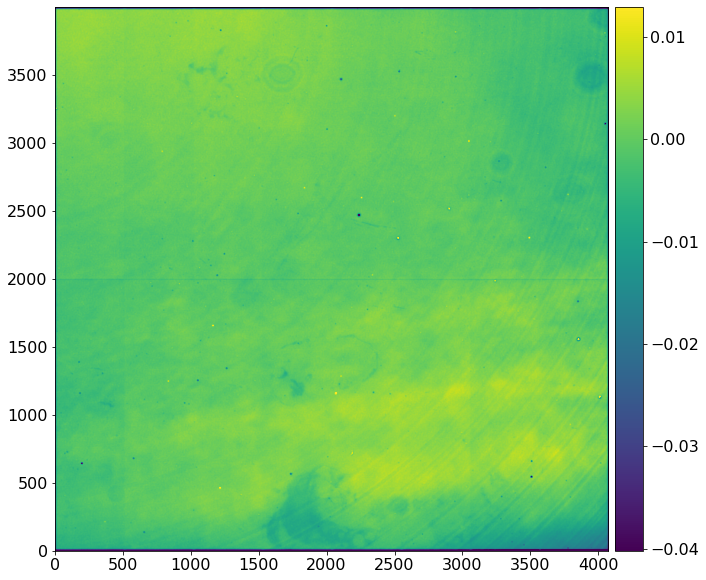

In [13]:
imshow(image)

### High Pass Filter

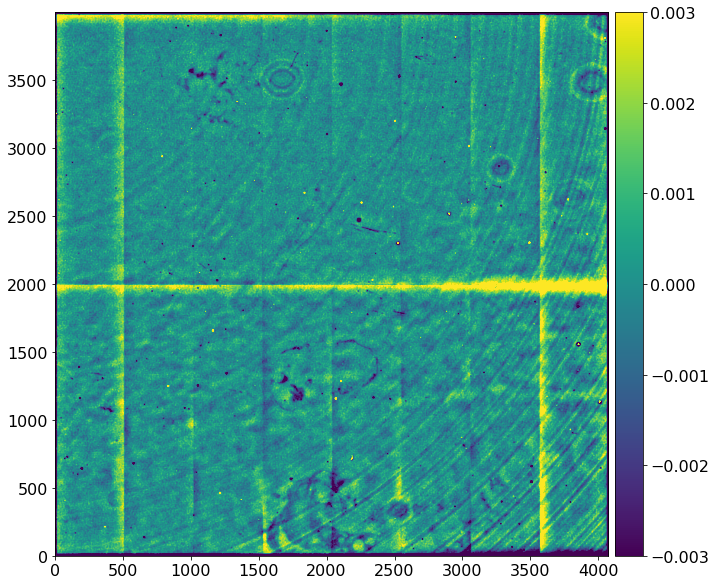

In [14]:
diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=True)
imshow(diff, interpolation='bicubic',vmin=-0.003,vmax=0.003)
# plt.title('%s, detector %s' % (ref.run, ref.dataId['detector']))

In [ ]:
sensor = 'itl'
hdu.data = diff
hdu.writeto('tmp/%s_flat_diff.fits'%(sensor))

## Pre-processing: smooth and masking

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

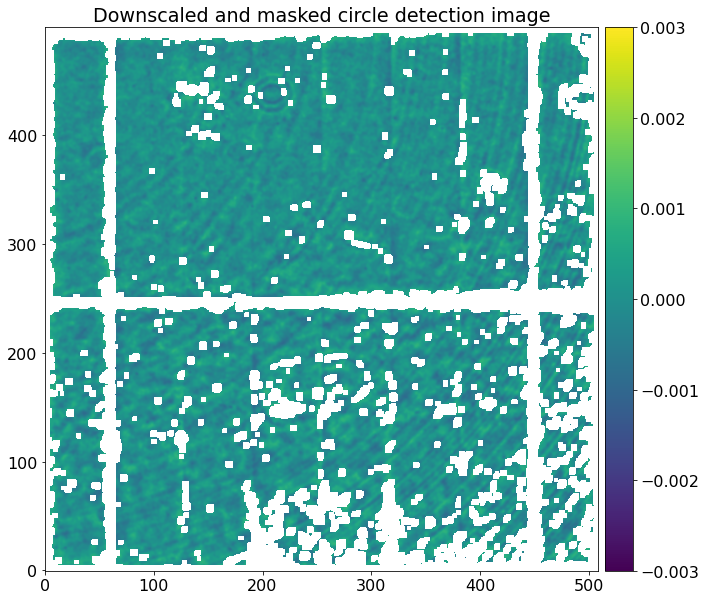

In [15]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.001 # For stronger rings
#threshold = 0.003 # For strongest rings

diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask , (downscale, downscale), func=np.nanmax)
diff2[mask2] = np.nan

imshow(diff2, interpolation='bicubic', vmin=-0.003, vmax=0.003)#
plt.title('Downscaled and masked circle detection image')

### Finding the TR Center

In [16]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

def fn_detect(p):
    '''Estimator to locate tree rings center in downscaled images'''
    r = np.hypot(x2-p[0], y2-p[1])
    idx = np.isfinite(diff2) & (diff2 != 0)
    v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.mean(r), np.max(r), 1.0))
    return -np.std(v[np.isfinite(v)])

def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
    '''Function to measure tree rings in original image given the center'''
    r = np.hypot(x-x0, y-y0)
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
    
    return 0.5*(bins[1:]+bins[:-1]), v

In [17]:
xlow, xhig = -800., 0.
ylow, yhig = 4000., 4800.

cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]], popsize=40)
print(cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.0001752845529177897
 message: 'Optimization terminated successfully.'
    nfev: 643
     nit: 7
 success: True
       x: array([-41.93623349, 511.98016503])

Original scale coordinates: -335.49, 4095.84


In [ ]:
## x0,y0 = -335.49, 4095.84
## std=0.00017528

### Diagnostic Plots

Text(0.5, 1.0, 'R02_S02_R02_S02_H_median.fits')

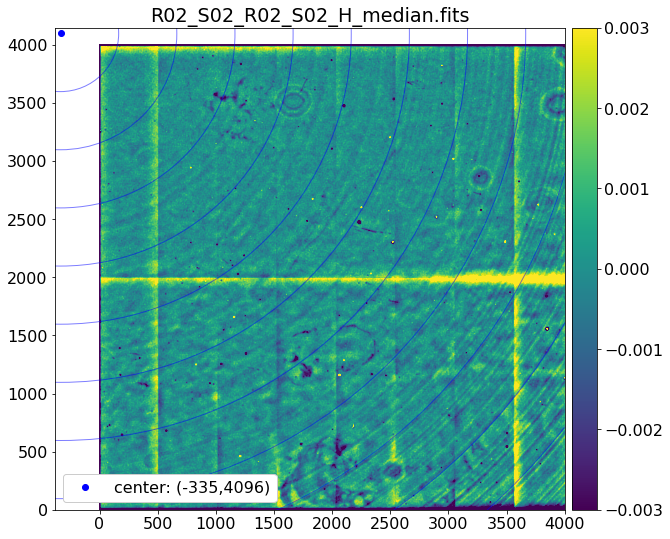

In [18]:
from matplotlib.patches import Circle

plt.figure(figsize=(10,12))

plt.subplot2grid((4,1),(0,0), rowspan=3)

imshow(diff, vmin=-0.003, vmax=0.003)
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.plot(x0, y0, 'o', color='blue', label="center: (%.0f,%.0f)" % (x0, y0))

# plt.text(x0+30, y0+30, "(%.0f,%.0f)" % (x0, y0))
plt.legend(frameon=True, framealpha=1)

for _ in np.arange(0, 6000, 500):
    plt.gca().add_patch(Circle((x0, y0), _, color='blue', ls='-', fc='none', alpha=0.5))

# plt.xlim(x0-50,4200)
# plt.ylim(-50,y0+50)

plt.xlim(x0-50,4000)
plt.ylim(0., y0+50)

# plt.xlim(x0-50,4000)
# plt.ylim(y0-50, 4000.)

# plt.show()

plt.title(itl2)


(3000.0, 6218.587188735368)

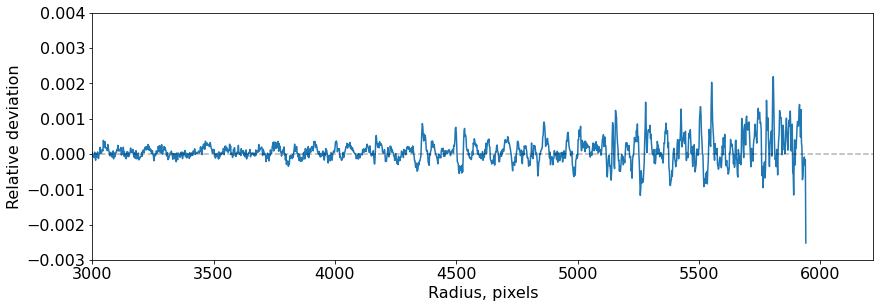

In [19]:
pos,v = fn_measure(x0, y0, mask=mask, step=2.0, statistic='mean')

plt.subplot(211)
plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.003, 0.004)
plt.xlim(3000,)

Will analyse the following radial interval: 1486 - 5717 pixels


<ipython-input-20-eae5b6438655>:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


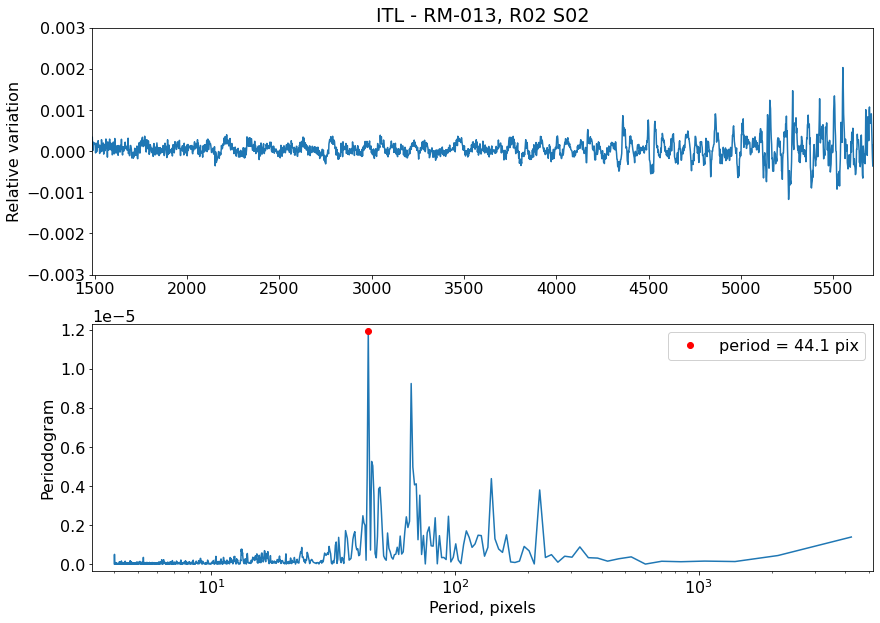

In [20]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylim(-0.003,0.003)
plt.ylabel('Relative variation')
plt.title('ITL - RM-013, R02 S02')

#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

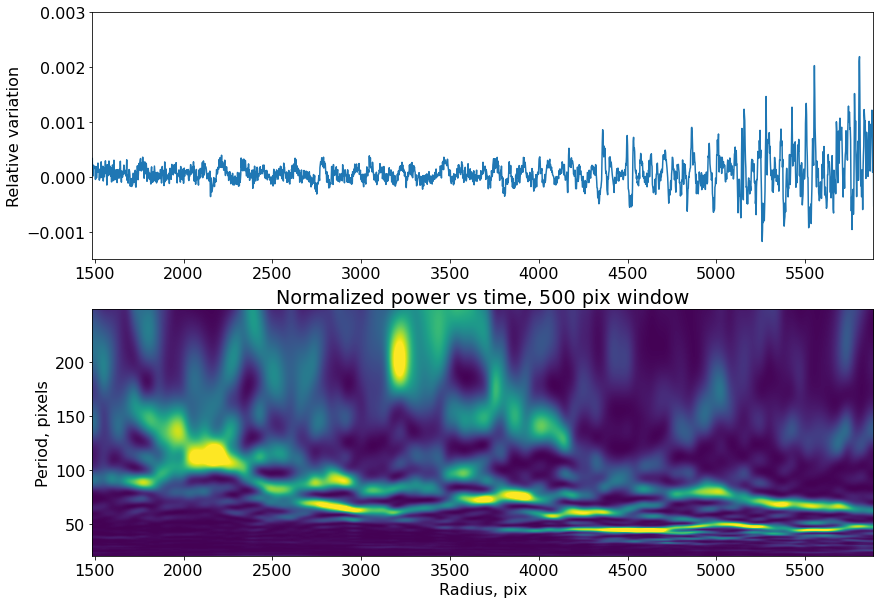

In [21]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


<ipython-input-22-deb69ba41938>:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


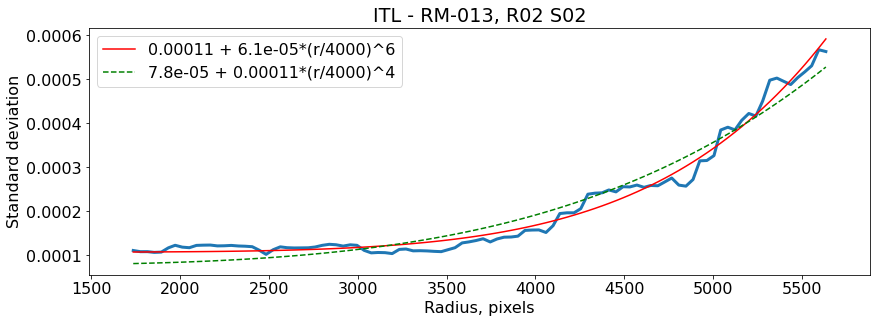

In [22]:
#lo = 3000
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

mids = np.array(mids)
stds = np.array(stds)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
plt.title('ITL - RM-013, R02 S02')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)

# E2V Tree Ring Center

In [23]:
image, hdu = load_image(path+etv2,sensor='e2v',overwrite=False)

## row flipped
image = np.flip(image,0)

tmp: found flat field
tmp/e2v_flat.fits


In [24]:
## Checking image shape: (4004, 4096)

image.shape

(4004, 4096)

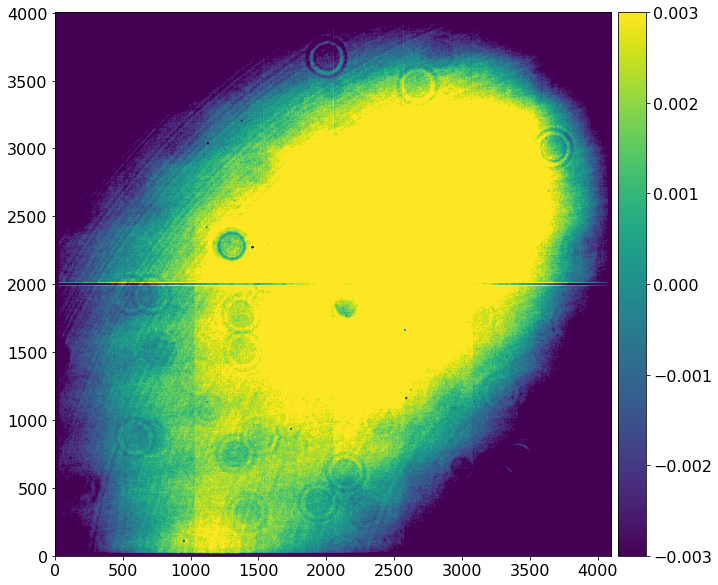

In [25]:
imshow(image,vmin=-0.003,vmax=0.003)

### High Pass Filter

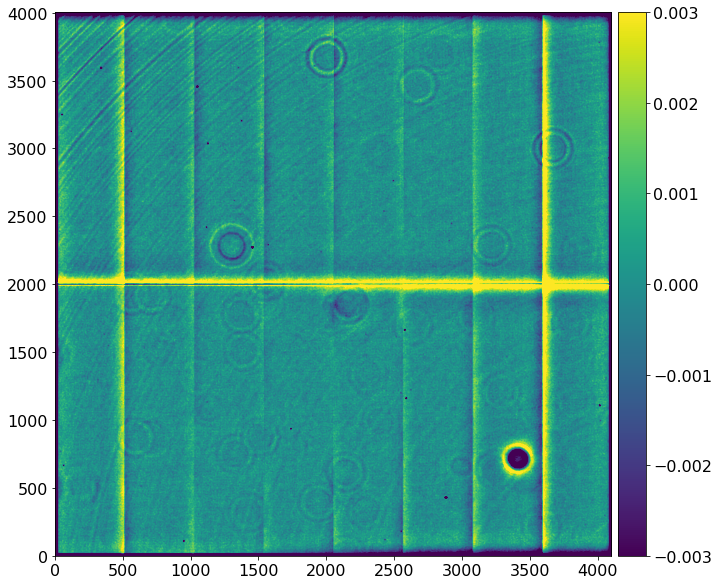

In [26]:
diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=True)
imshow(diff, interpolation='bicubic',vmin=-0.003,vmax=0.003)
# plt.title('%s, detector %s' % (ref.run, ref.dataId['detector']))

In [ ]:
sensor = 'e2v'
hdu.data = diff
hdu.writeto('tmp/%s_flat_diff.fits'%(sensor))

## Pre-processing: smooth and masking

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

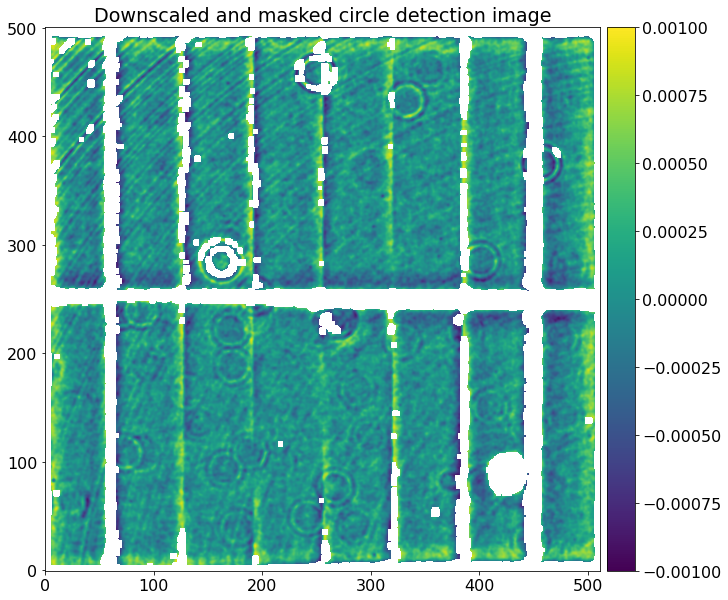

In [27]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.002 # For stronger rings
threshold = 0.001 # For strongest rings

diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask, (downscale, downscale), func=np.nanmax)
diff2[mask2] = None

imshow(diff2, interpolation='bicubic', vmin=-0.001, vmax=0.001)#
plt.title('Downscaled and masked circle detection image')

### Finding the TR Center

In [28]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x   = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

In [29]:
ylow, yhig = -1000., 0.
xlow, xhig = 4000., 5000.

cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]], popsize=40)
print(cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.00014681790280816448
 message: 'Optimization terminated successfully.'
    nfev: 883
     nit: 10
 success: True
       x: array([578.43346447, -78.8617629 ])

Original scale coordinates: 4627.47, -630.89


In [30]:
# x0, y0, std = 4627.47, -630.89, 0.00014681
# x0, y0 =4667, -678

### Diagnostic Plots

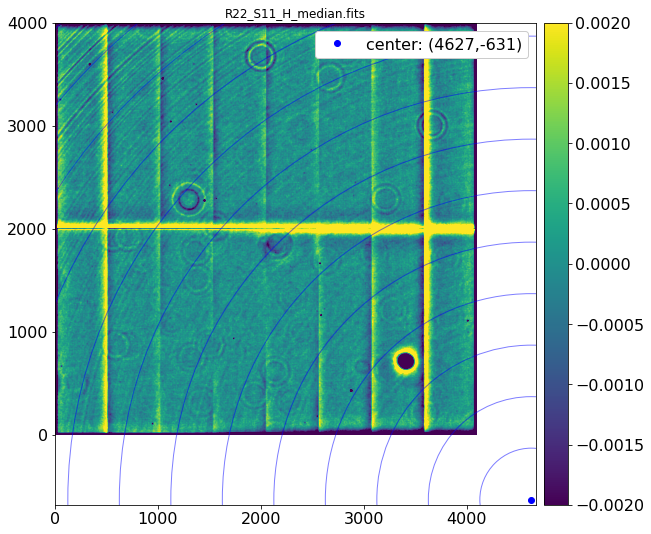

In [31]:
from matplotlib.patches import Circle

plt.figure(figsize=(10,12))

plt.subplot2grid((4,1),(0,0), rowspan=3)

imshow(diff, vmin=-0.002, vmax=0.002)
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.plot(x0, y0, 'o', color='blue', label="center: (%.0f,%.0f)" % (x0, y0))

# plt.text(x0+30, y0+30, "(%.0f,%.0f)" % (x0, y0))
plt.legend(frameon=True, framealpha=1)

for _ in np.arange(0, 7000, 500):
    plt.gca().add_patch(Circle((x0, y0), _, color='blue', ls='-', fc='none', alpha=0.5))

# plt.xlim(x0-50,4200)
# plt.ylim(-50,y0+50)

plt.ylim(y0-50,4000)
plt.xlim(0., x0+50)

plt.title('R22_S11_H_median.fits',fontsize=12)
# plt.show()

# Now make less restrictive mask
# mask = np.abs(diff1) > 0.002

pos,v = fn_measure(x0, y0, mask=mask, step=1.0, statistic='mean')
# plt.subplot(211)
# plt.subplot2grid((4,1),(3,0), rowspan=1)

# plt.plot(pos, v, '-')
# plt.axhline(0, color='black', alpha=0.3, ls='--')
# plt.xlabel('Radius, pixels')
# plt.ylabel('Relative deviation')
# # plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
# plt.ylim(-0.002, 0.002)
# plt.tight_layout()

(5100.0, 6766.309954114582)

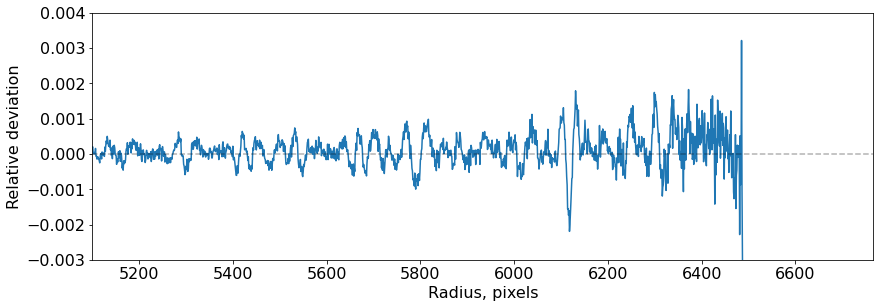

In [32]:
plt.subplot(211)
plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.003, 0.004)
plt.xlim(5100,)

Will analyse the following radial interval: 2019 - 6264 pixels


<ipython-input-36-42fb409ea4f5>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


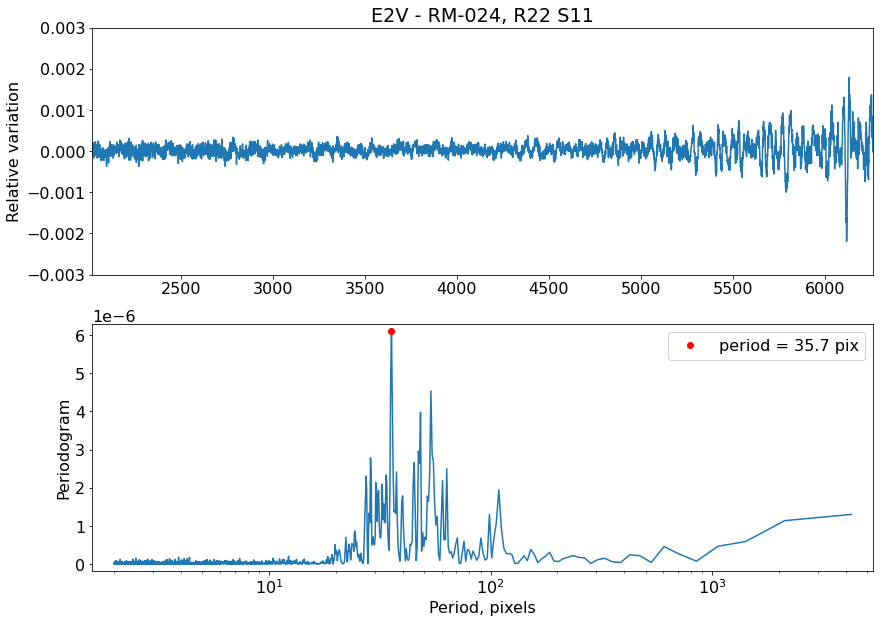

In [36]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
plt.ylim(-0.003, 0.003)
plt.title('E2V - RM-024, R22 S11')

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

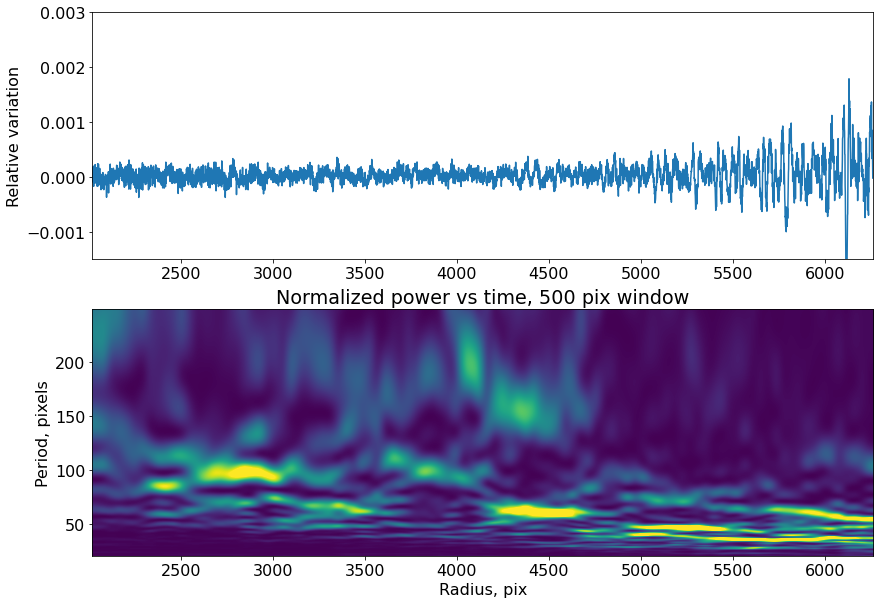

In [34]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


<ipython-input-35-57fd0f3833f5>:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


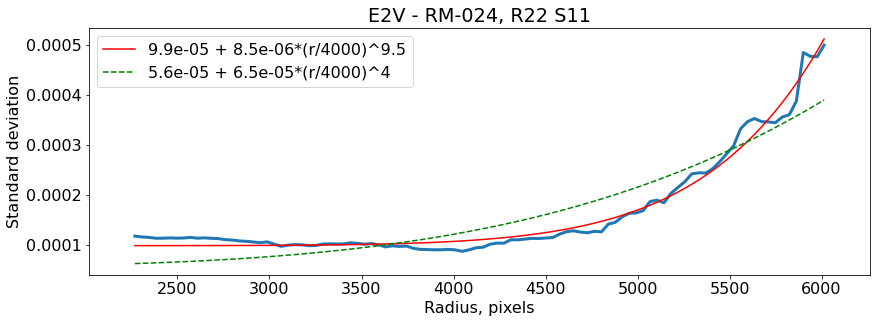

In [35]:
#lo = 3000
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

mids = np.array(mids)
stds = np.array(stds)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
plt.title('E2V - RM-024, R22 S11')

#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)